## Demonstration of Effect of Quantization and Frequency cut-off done during JPEG Compression

In this project, I am trying to imitate the few steps (symbol encoder block is not implemented) in JPEG compression to show the effect of quantization and the frequency cut-off. The JPEG compression algorithm consists of following steps:
- Input Image M x N
- Contruct n x n subimages
- Forward Transform
- Quantizer
- Symbol encoder
- Compressed Image

JPEG sees image as Black and white / Gray image, so for RGB images it is first needed to be converted to YCbCr form, where Cb and Cr helps to contruct colors in the image and Y is the gray scale version of that image.


#### Algorithm of the project:

- Receive an input image 3 x (M-j) X (N-k), where M and N equals to 2^x and 2^y, x and y are any positive integer.

- Convert this RGB image into YCbCr image and take only Y for the purpose of demonstration.

- Pad this image to get shape of M X N.

- Divide the image into non-overlapping 8x8 blocks.

- Compute the DFT (discrete fourier transform) of each block.

- Quantize each block by divide each coefficient by some number, round the result to the nearest integer, and multiply back by that same number. Try changing the value to see the effect.

- Try preserving the 8 largest coefficients (out of the total of 8x8=64). Or try decreasing and increasing the number of coefficients to preserve in order to see the effect.

- In JPEG compression, we actually perform symbol encoding and save our file. But since we are not doing this for storage, we will now visualize the result.

- Perform the Inverse DFT.

- Visualize the results.

The main algorithm that is affecting the image compression performance is Discrete Fourier and Inverse Discrete Fourier Transform. Another algorithm that is used in the compression process is sorting algorithm. I used the default 'quicksort' algorithm to do the job.

#### Discrete Fourier Transform

Source: https://homepages.inf.ed.ac.uk/rbf/HIPR2/fourier.htm

The Fourier Transform is an important image processing tool which is used to decompose an image into its sine and cosine components. The output of the transformation represents the image in the Fourier or Frequency domain, while the input image is the spatial domain equivalent. In the Fourier domain image, each point represents a particular frequency contained in the spatial domain image.

DFT is the sampled Fourier Transform and therefore doesn't contain all frequencies forming an image, but only a set of samples which is large enough to fully describe the spatial domain image. The number of frequencies corresponds to the number of pixels in the spatial domain image, i.e. the image in the spatial and Fourier domain are of the same size.

For an image of size M x N, the two dimensional DFT is given by:

$$ F(k,l) = \Sigma_{i=0}^{M-1}{\Sigma_{j=0}^{N-1}{f(i,j)\exp^{-\textbf{i}2\pi(\frac{ki}{M} + \frac{lj}{N})}}} $$

where f(a,b) is the image in the spatial domain and the exponential term is the basis function corresponding to each point F(k,l) in the Fourier space. The equation can be interpreted as: the value of each point F(k,l) is obtained by multiplying the spatial image with the corresponding base fucntion and summing the result.

The basis functions are sine and cosine waves with increasing frequencies, i.e. F(0,0) represents the DC component of the image which corresponds to the average brightness and F(M-1, N-1) represents the highest frequency.

In a similar way, the Fourier image can be re-transformed to the spatial domain. The inverse Fourier transform is given by:

$$ f(a,b) = \frac{1}{N*M} \Sigma_{k=0}^{M-1}{\Sigma_{l=0}^{N-1}{F(k,l)\exp^{\textbf{i}2\pi(\frac{ka}{M} + \frac{lb}{N})}}} $$

Complexity: The ordinary one-dimensional DFT and iDFT has $ N^2 $ complexity. In our case, two-dimensional DFT and iDFT has $ M^2N^2  $ complexity, since F(a,b) needs to be computed for a = 0 to M-1 and b = 0 to N-1. We can use matrix multiplication in order to improve the performance rather than just using dumb for loop by computing the matrix of the basis function.

#### Fast Fourier Transform

The $ N^2 $ complexity of 1-D DFT can be reduced to $ N \log_2N $ if we employ the Fast Fourier Transform (FFT) to compute DFTs. This is a significant improvement, in particular for large images. Exploiting the symmetry and periodicity property of dft calculation of 1D dft is reduced to half by dividing N point DFTs to two N/2 point DFTs (even and odd samples). Similarly, again N/2 point DFTs is divided into two N/4 point DFTs (even and odd samples), until we reach 2 point DFTs and now we compute the 2 point DFT using the normal DFTs. This is the Fast Fourier Tranform.

#### Discrete Cosine Transform

This is another sinusoidal transform which is related to DFT. The main advantages of the DCT are that it yields a real valued output image and that it is a fast tranform. A major use of the DCT is in image compression i.e. trying to reduce the amount of data needed to store an image. We actually used DCT to demonstrate the effect. But we can use DFT as well to do that.

#### Concept of cutting or removing high frequency coefficients for image compression

After performing a DCT it is possible to throw away the coefficients that encode high frequecy components that human eye is not very sensitive to. Thus the amount of data can be reduced, without seriously affecting the way an image looks to the human eye.


#### Performance of Custom DFT, FFT and FFT-DCT

Obviously, DFT is the slowest of all. And FFT and FFT-DCT are almost the same, their difference is quite small. FFT-DCT is faster than FFT.


In [1]:
# !pip install ipywidgets
# !jupyter nbextension enable --py widgetsnbextension

In [2]:
import numpy as np
from scipy.fft import dct, idct
from PIL import Image
import PIL
import cmath

import matplotlib.pyplot as plt

In [3]:
# Reference:
# https://github.com/joyeecheung/SE-343-Digital-Image-Processing/blob/master/toys/fourier.py

import functools

def dftmtx(N):
    """Get discrete fourier transform matrix of size N x N."""
    n = np.asmatrix(np.arange(N))
    return np.exp((-2j * np.pi / N) * n.T * n)


def idftmtx(N):
    """Get inverse discrete fourier transform matrix of size N x N."""
    n = np.asmatrix(np.arange(N))
    return np.exp((2j * np.pi / N) * n.T * n)

def pow2_ceil(x):
    return 2 ** int(np.ceil(np.log2(x)))

def pad(data):
    M, N = data.shape
    P, Q = pow2_ceil(M), pow2_ceil(N)
    temp = np.zeros((P, Q))
    temp[:M, :N] = data
    return temp

def unpad(data, M, N):
    return data[:M,:N]

def fft(x):
    """Vectorized & iterative FFT."""
    x = np.asarray(x, dtype=complex)
    N = len(x)
    temp = x.reshape((1, N))
    
    while temp.shape[0] < N:
        m, n = temp.shape
        odd, even = temp[:, int(n / 2):], temp[:, :int(n / 2)]
        coff = np.exp(-1j * np.pi * np.arange(m) / m)[:, None]
        temp = np.vstack((even + coff * odd, even - coff * odd))

    return temp.ravel()



def get_2d(data, fn):
    """Apply `fn` to each row, then to each column."""
    
    result = np.copy(data)
    result = np.array([fn(row) for row in result])
    result = np.array([fn(col) for col in result.T])
    return result.T

def get_fft(data):
    if len(data.shape) == 1:
        return fft(data)
    return get_2d(data, fft)


def get_ifft(data):
    Fstar = np.conj(data)
    fstar = get_fft(Fstar) / functools.reduce(np.multiply, data.shape, 1.0)
    return np.conj(fstar)


def get_dft(data):
    """Get discrete fourier transform of data(numpy matrix/array)."""
    if len(data.shape) == 1:
        return (dftmtx(len(data)) * data[:, None]).A1
    M, N = data.shape
    return np.asarray(dftmtx(M) * data * dftmtx(N))

def get_idft(data):
    """Get inverse discrete fourier transform of data(numpy matrix/array)."""
    if len(data.shape) == 1:
        return (idftmtx(len(data)) * data[:, None] / len(data)).A1
    M, N = data.shape
    return np.asarray(idftmtx(M) * data * idftmtx(N) / (M * N))


In [4]:
def dumb_dft(data):
    dft = np.zeros(shape = data.shape)
    dft = np.asarray(dft, dtype=complex)
    m,n = data.shape
    for k in range(m):
        for l in range(n):
            for i in range(m):
                for h in range(n):
                    dft[k,l] = dft[k,l] + data[i,h] * np.exp(-2j * np.pi * (k/m*i + l/n*h))
    return dft

    
def dumb_idft(data):
    idft = np.zeros(shape = data.shape)
    idft = np.asarray(idft, dtype=complex)
    m,n = data.shape
    for k in range(m):
        for l in range(n):
            for i in range(m):
                for h in range(n):
                    idft[k,l] = idft[k,l] + data[i,h] * np.exp(2j * np.pi * (k/m*i + l/n*h))
            # idft[k,l] = 1/(m*n) * idft[k,l]
    return idft/(m*n)
    

In [8]:
import timeit
import matplotlib.pyplot as plt


def function_for_comparision(c):
    output.clear_output()
    out.clear_output()
    # thread.start() # progress bar
    s = 16
    num_size = 8
    sizes = [16*i for i in range(1, num_size+1)]
    loop = 10
    time = np.full(shape = (5, len(sizes)), fill_value = np.inf)
    # function_for_compression(a = 8, b = 2, ft = get_fft, ift = get_ifft)
    with output:
        print('Estimating time for dumb dft function...')
        %timeit function_for_compression(a = 8, b = 2, img_size = s, ft = dumb_dft, ift = dumb_idft, show_image = False)
        print('\nEstimating time for Custom dumb fft function...')
        %timeit function_for_compression(a = 8, b = 2, img_size = s, ft = get_fft, ift = get_ifft, show_image = False)
        print('\nEstimating time for Custom smart dft function...')
        %timeit function_for_compression(a = 8, b = 2, img_size = s, ft = get_dft, ift = get_idft, show_image = False)
        print('\nEstimating time for built-in Numpy fft function...')
        %timeit function_for_compression(a = 8, b = 2, img_size = s, ft = np.fft.fft, ift = np.fft.ifft, show_image = False)  
        print('\nEstimating time for built-in Scipy fft dct function...')
        %timeit function_for_compression(a = 8, b = 2, img_size = s, ft = dct, ift = idct, show_image = False)
        
        print('\n')
        for i, s in enumerate(sizes):
            print(f'Computing time for input size: {s} ...')
            for l in range(loop):
                if i<num_size/4:
                    st = timeit.default_timer()
                    function_for_compression(a = 8, b = 2, img_size = s, ft = dumb_dft, ift = dumb_idft, show_image = False)
                    diff = timeit.default_timer() - st
                    if diff < time[0,i]:
                        time[0,i] = diff
                    # time[0,i] += (timeit.default_timer() - st)
                if i<num_size/2:
                    st = timeit.default_timer()
                    function_for_compression(a = 8, b = 2, img_size = s, ft = get_fft, ift = get_ifft, show_image = False)
                    # time[1,i] += (timeit.default_timer() - st)
                    diff = timeit.default_timer() - st
                    if diff < time[1,i]:
                        time[1,i] = diff
                
                st = timeit.default_timer()
                function_for_compression(a = 8, b = 2, img_size = s, ft = get_dft, ift = get_idft, show_image = False)
                # time[2,i] += (timeit.default_timer() - st)
                diff = timeit.default_timer() - st
                if diff < time[2,i]:
                    time[2,i] = diff
                
                st = timeit.default_timer()
                function_for_compression(a = 8, b = 2, img_size = s, ft = np.fft.fft, ift = np.fft.ifft, show_image = False)
                # time[3,i] += (timeit.default_timer() - st)
                diff = timeit.default_timer() - st
                if diff < time[3,i]:
                    time[3,i] = diff
                
                st = timeit.default_timer()
                function_for_compression(a = 8, b = 2, img_size = s, ft = dct, ift = idct, show_image = False)
                # time[4,i] += (timeit.default_timer() - st)
                diff = timeit.default_timer() - st
                if diff < time[4,i]:
                    time[4,i] = diff
                
            # time[:,i] = time[:,i] / loop
        
        plt.figure()
        plt.plot(sizes[:int(num_size/4)], time[0,:int(num_size/4)], label="Naive dft")
        plt.plot(sizes[:int(num_size/2)], time[1,:int(num_size/2)], label="Naive fft")
        plt.plot(sizes, time[2,:], label="smart dft")
        plt.plot(sizes, time[3,:], label="numpy fft")
        plt.plot(sizes, time[4,:], label="scipy fft-dct")
        plt.xlabel("Input image size")
        plt.ylabel("Time")
        plt.legend()
        plt.show()
        

In [9]:
from IPython.display import display, Markdown, clear_output

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import timeit

import threading
import time

# progress = widgets.FloatProgress(value=0.0, min=0.0, max=1.0)

# thread = threading.Thread(target=work, args=(progress,))
# display(progress)

a = widgets.IntSlider(value=0,
                        min=0,
                        max=64,
                        step=1,
                        description='Frequency cut-off',
                        disabled=False,
                        continuous_update=False)

b = widgets.IntSlider(value=1,
                        min=1,
                        max=500,
                        step=1,
                        description='Quantization',
                        disabled=False,
                        continuous_update=False)

dc_slider = widgets.IntSlider(value=0,
                        min=0,
                        max=100,
                        step=1,
                        description='DC Component Reducer',
                        disabled=False,
                        continuous_update=False)

button = widgets.Button(
    description='Compare Compression Time',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
    icon='check' # (FontAwesome names without the `fa-` prefix)
)

clear_button = widgets.Button(
    description='Clear Output',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
    icon='check' # (FontAwesome names without the `fa-` prefix)
)

checkbox = widgets.Checkbox(
    value=False,
    description='Cut out DC component',
    disabled=False,
    indent=False
)

def function_for_compression(a, b, img_size = 16, ft = np.fft.fft, ift = np.fft.ifft, show_image = True):
    # print('{}'.format(a))
    img1 = np.array(Image.open("test_scene.jpg").convert('YCbCr'))
    # print(img1.shape)
    img = img1[:img_size,:img_size,0].copy()
    new_img = np.zeros_like(img)
    # plt.figure(figsize = (12,10))
    # plt.imshow(img, cmap='gray')

    for h in range(8,img.shape[0],8):
        for w in range(8, img.shape[1],8):

            temp = ft(img[h-8:h,w-8:w])
            
            # cutting higher frequency which are not visible to human eye
            sorted_index = np.argsort(temp, axis = None)
            temp = temp.flatten()
            temp[sorted_index[:-a]] = 0
            temp = temp.reshape(8,8)
            
            # this failed
            # temp = temp.flatten()
            # temp[:-a] = 0
            # temp = temp.reshape(8,8)
            
            # quantization
            if temp.dtype == 'complex':
                temp.real = (temp.real / b).astype('int') * b
                temp.imag = (temp.imag / b).astype('int') * b

            else:
                temp = (temp / b).astype('int') * b
                
            inv_fft_img = ift(temp)
            new_img[h-8:h,w-8:w] = inv_fft_img.real
    
    if show_image:
        image = Image.fromarray(new_img.astype(np.uint8))
        plt.figure(figsize = (12,10))
        plt.imshow(image, cmap="gray")
        if a!=0:
            plt.title(f"Compressed image with quantization level: {b}, number of low frequencies kept: {a}")
        else:
            plt.title(f"Compressed image with quantization level: {b}, number of low frequencies kept: {a+64}")


def function_for_compression_dct(a, b, dc_slider, checkbox, ft = dct, ift = idct, show_image = True):
    
    # output.clear_output()
    img1 = np.array(Image.open("test_scene.jpg").convert('YCbCr'))
    img = img1[:,:,0].copy()
    new_img = np.zeros_like(img)

    for h in range(8, img.shape[0], 8):
        for w in range(8, img.shape[1], 8):

            temp = ft(img[h-8:h,w-8:w])
            
            temp = temp.astype('int')
            
            # cutting higher frequency which are not visible to human eye
            sorted_index = np.argsort(temp, axis = None)
            temp = temp.flatten()
            temp[sorted_index[:-a]] = 0
            
            # cutting dc component
            if checkbox:
                temp[0] = temp[0] - dc_slider
            
            temp = temp.reshape(8,8)
            
            temp = (temp / b).astype('int') * b

            inv_fft_img = ift(temp)
            new_img[h-8:h,w-8:w] = inv_fft_img
    
    if show_image:
        image = Image.fromarray(new_img.astype(np.uint8))
        plt.figure(figsize = (12,10))
        plt.imshow(image, cmap="gray")
        if a!=0:
            plt.title(f"Compressed image with quantization level: {b}, number of top coefficients of frequencies kept: {a}")
        else:
            plt.title(f"Compressed image with quantization level: {b}, number of top coefficients of frequencies kept: {a+64}")


            
def clear_output(a):
    out.clear_output()
    output.clear_output()

out = widgets.interactive_output(function_for_compression_dct, {'a': a, 'b': b, 'dc_slider': dc_slider, 'checkbox': checkbox})
# out2 = widgets.interactive_output(function_for_comparision, {'c':button.on_click})

output = widgets.Output() #output for comparision

button.on_click(function_for_comparision)

clear_button.on_click(clear_output)

widgets.VBox([widgets.HBox([a, b]), widgets.HBox([checkbox, dc_slider]), widgets.HBox([button, clear_button]), output, out])

### Testing

In [130]:
import threading
from IPython.display import display
import ipywidgets as widgets
import time
progress = widgets.FloatProgress(value=0.0, min=0.0, max=1.0)

def work(progress):
    total = 100
    for i in range(total):
        time.sleep(0.2)
        progress.value = float(i+1)/total

thread = threading.Thread(target=work, args=(progress,))
display(progress)
thread.start()

FloatProgress(value=0.0, max=1.0)

In [98]:
from IPython.display import display

button = widgets.Button(description="Click Me!")
output = widgets.Output()

display(button, output)

def on_button_clicked(b):
    with output:
        print("Button clicked.")

button.on_click(on_button_clicked)

Button(description='Click Me!', style=ButtonStyle())

Output()

In [159]:
image_upload = widgets.FileUpload(accept='.jpg',  # Accepted file extension e.g. '.txt', '.pdf', 'image/*', 'image/*,.pdf'
                                    multiple=False  # True to accept multiple files upload else False
                                )

display(image_upload)

# upload something...

# once a file is uploaded, use the `.value` attribute to retrieve the content:
print(image_upload.value)



FileUpload(value={}, accept='.jpg', description='Upload')

{}


### JPEG compression
- Divide the image into non-overlapping 8x8 blocks.

- Compute the DCT (discrete cosine transform) of each block. This is implemented in popular packages such as Matlab.

- Quantize each block. You can do this using the tables in the video or simply divide each coefficient by N, round the result to the nearest integer, and multiply back by N. Try for different values of N.

- You can also try preserving the 8 largest coefficients (out of the total of 8x8=64), and simply rounding them to the closest integer.

- Visualize the results after inverting the quantization and the DCT.

**Low pass filter (smooth), high pass filter (sharpening), and any filter in frequency domain**

In [ ]:

img1 = np.array(Image.open("edit11.jpg").convert('YCbCr'))
print(img1.shape)
img = img1[:,:,0].copy()
new_img = np.zeros_like(img)
plt.figure(figsize = (12,10))
plt.imshow(img, cmap='gray')

for h in range(8,img.shape[0],8):
    for w in range(8, img.shape[1],8):
        
        temp = np.fft.fft(img[h-8:h,w-8:w])
        sorted_index = np.argsort(temp, axis = None)
        temp = temp.flatten()
        temp[sorted_index[:-8]] = 0
        temp = temp.reshape(8,8)

        inv_fft_img = np.fft.ifft(temp)
        new_img[h-8:h,w-8:w] = inv_fft_img.real

image = Image.fromarray(new_img.astype(np.uint8))
plt.figure(figsize = (12,10))
plt.imshow(image, cmap="gray")

In [104]:
a = np.array([[10,3,4],[4,5,2]])
s = np.argsort(a, axis=None)
b = a.flatten()
print(s)
print(b)
b[s[:-2]] = 0
b.reshape(2,3)

[5 1 2 3 4 0]
[10  3  4  4  5  2]


array([[10,  0,  0],
       [ 0,  5,  0]])

In [61]:
pow2_ceil(10)

16

In [20]:
# Reference:
# https://github.com/joyeecheung/SE-343-Digital-Image-Processing/blob/master/toys/fourier.py

import functools


def dftmtx(N):
    """Get discrete fourier transform matrix of size N x N."""
    n = np.asmatrix(np.arange(N))
    return np.exp((-2j * np.pi / N) * n.T * n)


def idftmtx(N):
    """Get inverse discrete fourier transform matrix of size N x N."""
    n = np.asmatrix(np.arange(N))
    return np.exp((2j * np.pi / N) * n.T * n)

def pow2_ceil(x):
    return 2 ** int(np.ceil(np.log2(x)))

def pad(data):
    M, N = data.shape
    P, Q = pow2_ceil(M), pow2_ceil(N)
    temp = np.zeros((P, Q))
    temp[:M, :N] = data
    return temp

def unpad(data, M, N):
    return data[:M,:N]

def fft(x):
    N = len(x)
    
    if N == 1:
        return x
    else:
        X_even = fft(x[::2])
        X_odd = fft(x[1::2])
        factor = \
          np.exp(-2j*np.pi*np.arange(N)/ N)
        
        X = np.concatenate(\
            [X_even+factor[:int(N/2)]*X_odd,
             X_even+factor[int(N/2):]*X_odd])
        return X


def get_2d(data, fn):
    """Apply `fn` to each row, then to each column."""
    result = np.copy(data)
    result = np.array([fn(row) for row in result])
    result = np.array([fn(col) for col in result.T])
    return result.T

def get_fft(data):
    if len(data.shape) == 1:
        return fft(data)
    return get_2d(data, fft)
    

def get_ifft(data):
    Fstar = np.conj(data)
    fstar = get_fft(Fstar) / functools.reduce(np.multiply, data.shape, 1.0)
    return np.conj(fstar)


def get_dft(data):
    """Get discrete fourier transform of data(numpy matrix/array)."""
    if len(data.shape) == 1:
        return (dftmtx(len(data)) * data[:, None]).A1
    M, N = data.shape
    return np.asarray(dftmtx(M) * data * dftmtx(N))


def get_idft(data):
    """Get inverse discrete fourier transform of data(numpy matrix/array)."""
    if len(data.shape) == 1:
        return (idftmtx(len(data)) * data[:, None] / len(data)).A1
    M, N = data.shape
    return np.asarray(idftmtx(M) * data * idftmtx(N) / (M * N))


In [21]:
img1 = np.array(Image.open("test.jpg").convert('YCbCr'))
# print(img1.shape)
img2 = img1[:,:,0].copy()
img = img2[:16,:16]
x_shape, y_shape = img.shape
# new_img = np.zeros_like(img)
# plt.figure(figsize = (12,10))
# plt.imshow(img, cmap='gray')


### DFT calculation ###

img = pad(img)

# custom fft function
c_fft = get_fft(img)

(750, 750, 3)


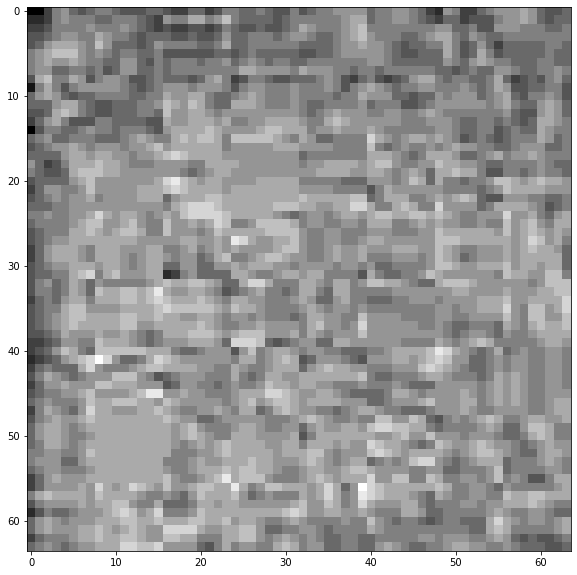

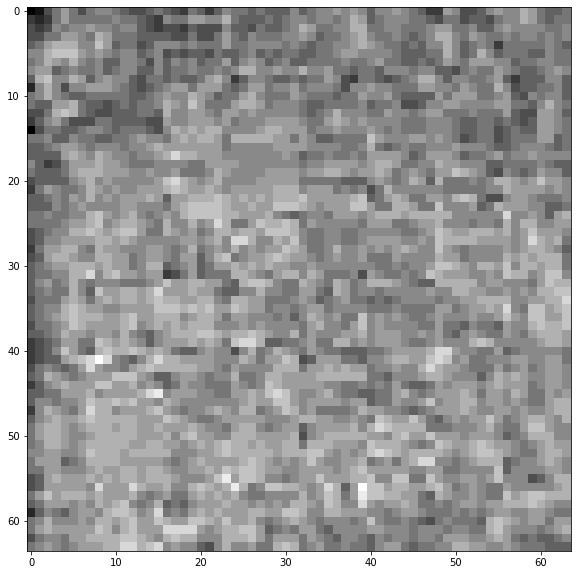

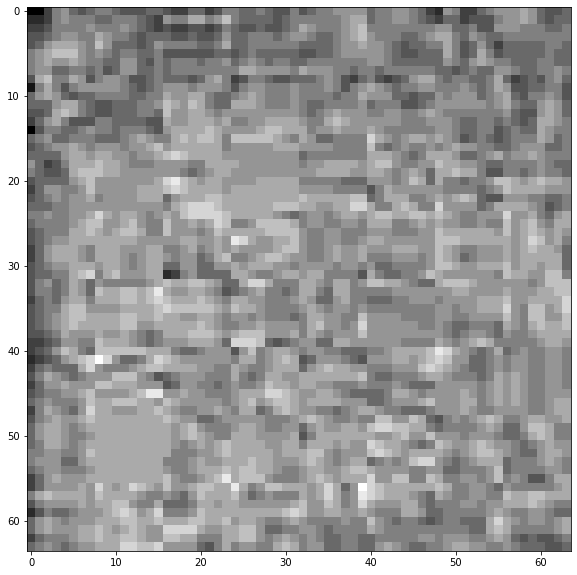

In [49]:

img1 = np.array(Image.open("test.jpg").convert('YCbCr'))
print(img1.shape)
img2 = img1[:,:,0].copy()
img = img2[:64,:64]
x_shape, y_shape = img.shape
# new_img = np.zeros_like(img)
plt.figure(figsize = (12,10))
plt.imshow(img, cmap='gray')


### DFT calculation ###

# custom dft function
img = pad(img)
c_dft = dumb_dft(img)

# custom fft function
c_fft = get_fft(img)
# c_fft[0,0] = 0


### IDFT Calcuation ###

#custom idft function
inv_fft_img = dumb_idft(c_dft)
new_img = inv_fft_img.real
new_img = unpad(new_img, x_shape, y_shape)

# custom ifft functino
inv_fft_img1 = get_ifft(c_fft)
new_img1 = inv_fft_img1.real
new_img1 = unpad(new_img1, x_shape, y_shape)


image = Image.fromarray(new_img.astype(np.uint8))
plt.figure(figsize = (12,10))
plt.imshow(image, cmap="gray")

image1 = Image.fromarray(new_img1.astype(np.uint8))
plt.figure(figsize = (12,10))
plt.imshow(image1, cmap="gray")

(3456, 5184, 3)


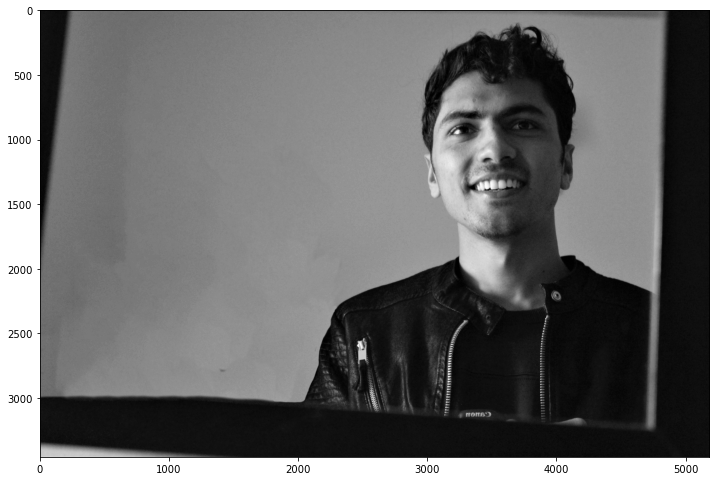

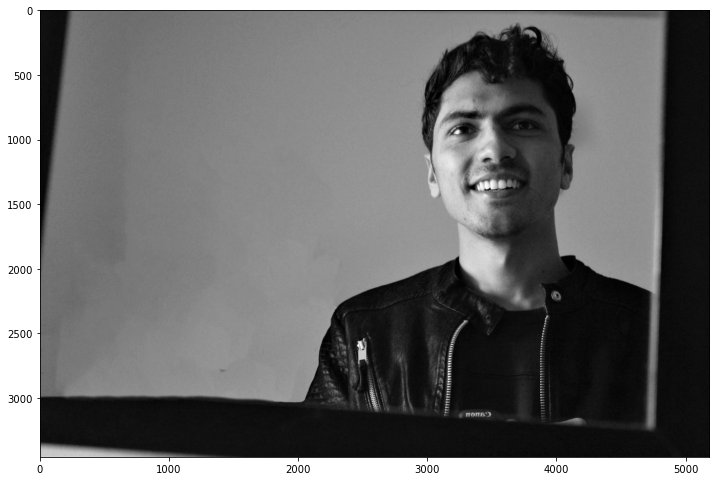

In [38]:

img1 = np.array(Image.open("edit11.jpg").convert('YCbCr'))
print(img1.shape)
img = img1[:,:,0].copy()
new_img = np.zeros_like(img)
plt.figure(figsize = (12,10))
plt.imshow(img, cmap='gray')
  
temp = np.fft.fft(img)

inv_fft_img = np.fft.ifft(temp)
new_img = inv_fft_img.real

image = Image.fromarray(new_img.astype(np.uint8))
plt.figure(figsize = (12,10))
plt.imshow(image, cmap="gray")

### Smoothing

In [59]:
average_filter = np.array([[1/9,1/9,1/9],[1/9,1/9,1/9],[1/9,1/9,1/9]])

img1 = np.array(Image.open("edit11.jpg").convert('YCbCr'))
print(img1.shape)
img = img1[:,:,0].copy()

fft_img = np.fft.fft2(img)
fft_conv_filter = np.fft.fft2(average_filter, (img.shape[0], img.shape[1]))

f_img_filter = np.multiply(fft_img, fft_conv_filter)
output = np.fft.ifft2(f_img_filter)



(3456, 5184, 3)


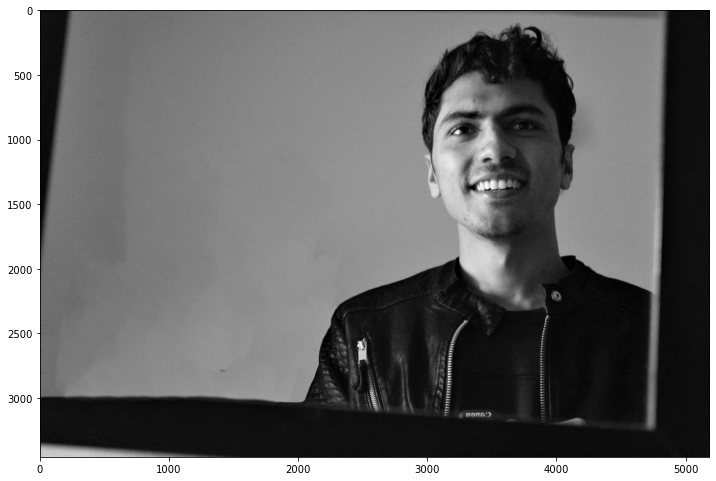

In [61]:
real_out = output.real.copy()
# real_out[real_out<2] = 0

image = Image.fromarray((real_out).astype(np.uint8))
plt.figure(figsize = (12,10))
plt.imshow(image, cmap="gray")

### Unsharp mask

In [95]:
average_filter = np.array([[1/9,1/9,1/9],[1/9,1/9,1/9],[1/9,1/9,1/9]])

img1 = np.array(Image.open("bwimage.jpg").convert('YCbCr'))
print(img1.shape)
img = img1[:,:,0].copy()

fft_img = np.fft.fft2(img)
fft_conv_filter = np.fft.fft2(average_filter, (img.shape[0], img.shape[1]))

f_img_filter = np.multiply(fft_img, fft_conv_filter)
output = np.fft.ifft2(f_img_filter)


(600, 800, 3)


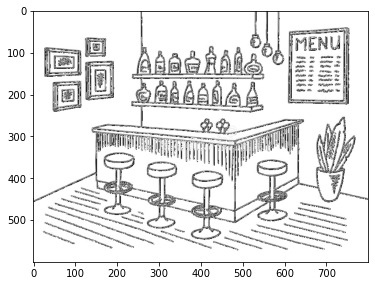

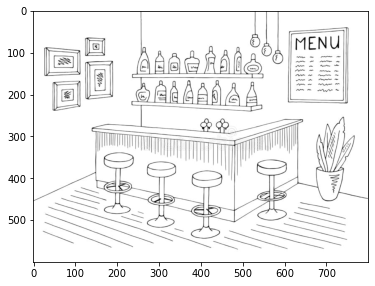

In [107]:
real_out = output.real.copy()
# real_out[real_out<2] = 0

image = Image.fromarray((img+ 0.08*(img-real_out)).astype(np.uint8))
plt.figure(figsize = (6,5))
plt.imshow(image, cmap="gray")
plt.figure(figsize = (6,5))
plt.imshow(img, cmap="gray")